# Laser segmentation in pattern

In this article a method to detect the laser stripe and generate a vector of 2D points is presented over the chessboard pattern.

In [1]:
%pylab inline
%matplotlib inline

from util import *

Populating the interactive namespace from numpy and matplotlib


## Pattern mask
Initially the pattern is detected to obtain a ROI (Region of interesnt) with the pattern shape. This ROI is applied as a mask to the image for the laser detection to avoid external speckles and noise. Only laser over pattern will be detected.

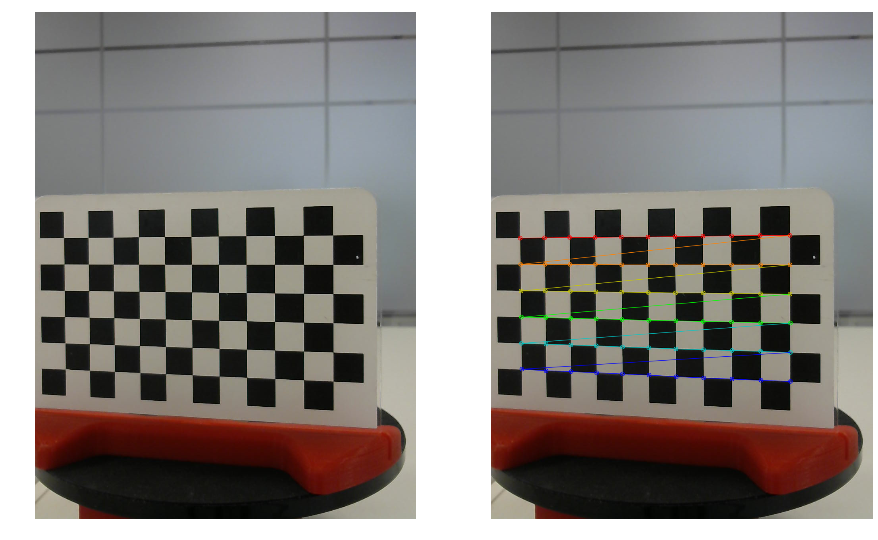

In [2]:
# Load image
image = load_image('images/3.2. Laser segmentation in pattern/pattern.png')
h, w, d = image.shape

# Pattern detection
corners, ret = pattern_detection(image)
image_corners = draw_pattern(image, corners, ret)

plot_images((image, image_corners))

Time: 0:00:00.002389


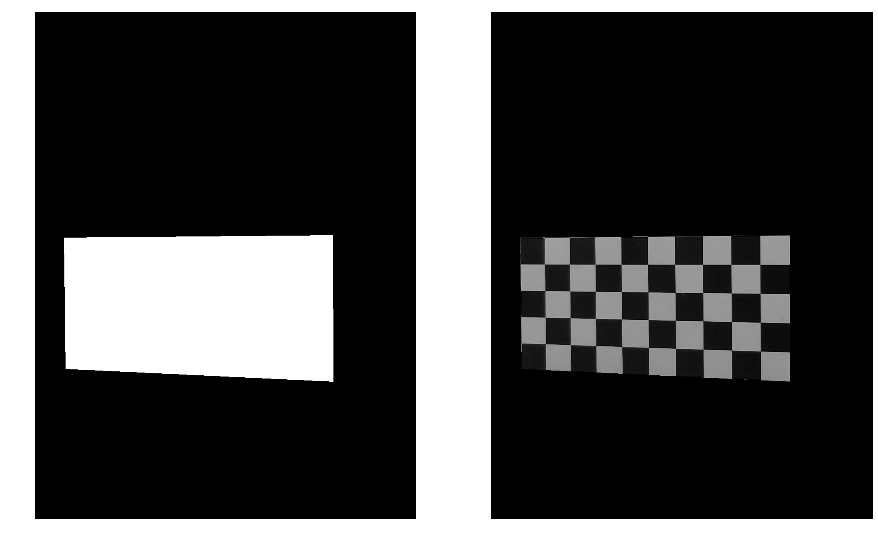

In [3]:
begin()

corners = corners.astype(np.int)
    
p1 = corners[0][0]
p2 = corners[columns - 1][0]
p3 = corners[columns * (rows - 1)][0]
p4 = corners[columns * rows - 1][0]

# Compute ROI

roi_mask = np.zeros((h, w), np.uint8)
points = np.array([p1, p2, p4, p3])
cv2.fillConvexPoly(roi_mask, points, 255)

end()

# Apply mask

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_gray = cv2.bitwise_and(image_gray, roi_mask)

plot_images((roi_mask, image_gray))

## Laser detection

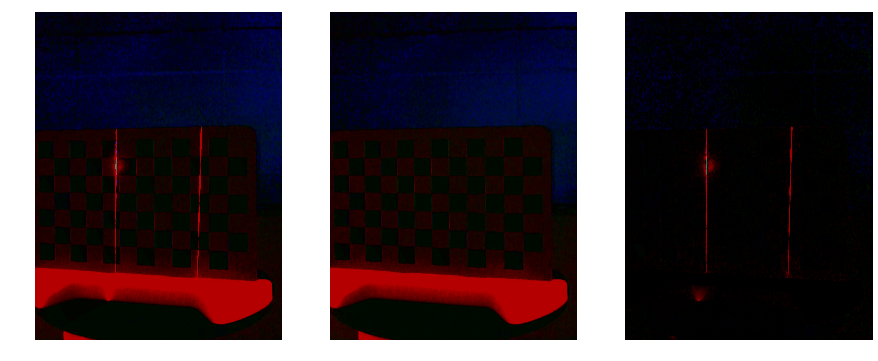

In [4]:
# Load images

image = load_image('images/3.2. Laser segmentation in pattern/laser-0-255-255-8-x.png')
image_background = load_image('images/3.2. Laser segmentation in pattern/laser-background-0-255-255-8-x.png')

plot_images((image, image_background, cv2.subtract(image, image_background)))

## Monochromatic space

### R from RGB

Time: 0:00:00.008855


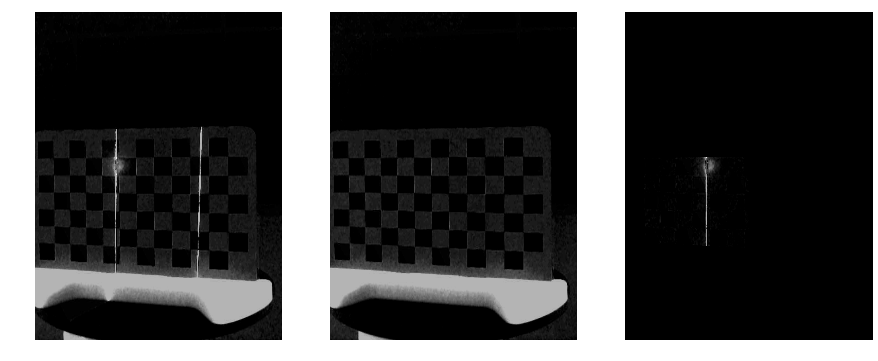

In [5]:
def r_rgb(image):
    return cv2.split(image)[0]

begin()

image_r = r_rgb(image)
image_background_r = r_rgb(image_background)
image_diff_r = cv2.subtract(image_r, image_background_r)

end()

# Hack to filter one laser (only for the example)
zeros = np.zeros((1280, 480), dtype=numpy.uint8)
ones = 255 * np.ones((1280, 480), dtype=numpy.uint8)
mask = np.concatenate((ones, zeros), axis=1)  # (zeros, ones)
image_diff_r = cv2.bitwise_and(image_diff_r, mask)

# ROI mask

image_diff_r = cv2.bitwise_and(image_diff_r, roi_mask)

plot_images((image_r, image_background_r, image_diff_r))

## Threshold
It is used to filter near line noise and also background noise.

$$
dst(x, y) =
  \begin{cases}
    src(x,y)       & \quad \text{if } src(x,y) \: > \text{ threshold}\\
    0       & \quad \text{otherwise } \\
  \end{cases}
$$

Time: 0:00:00.006132


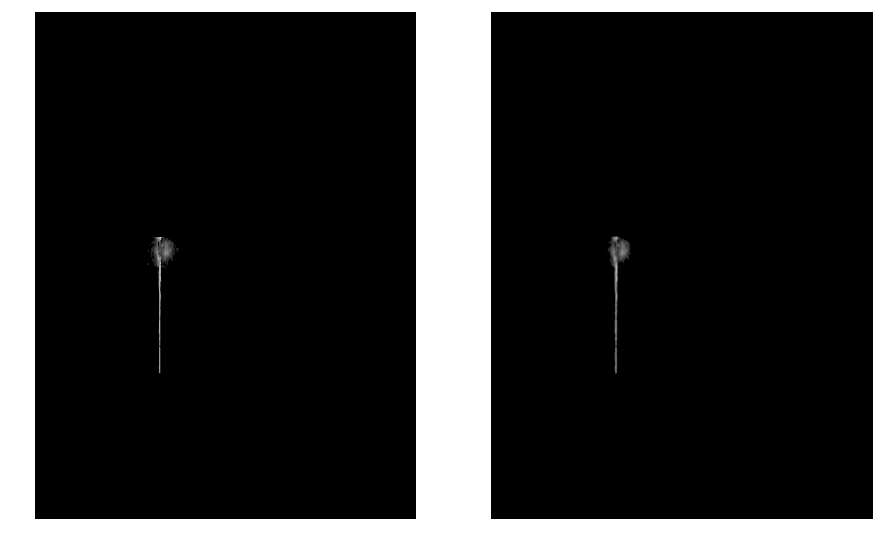

In [6]:
# Threshold image

begin()

threshold_value = 30
image_threshold = cv2.threshold(image_diff_r, threshold_value, 255, cv2.THRESH_TOZERO)[1]

# Blur image

blur_value = 5
image_blur = cv2.blur(image_threshold, (blur_value, blur_value))

image_blur_threshold = cv2.threshold(image_blur, threshold_value, 255, cv2.THRESH_TOZERO)[1]

end()

plot_images((image_threshold, image_blur_threshold))

## Valid window mask
It is computed for each row a window around the intensity peak value in order to apply a mask to the image to avoid possible speckles and background noise. This mask is applied to the original monochromatic image.

Time: 0:00:00.009796


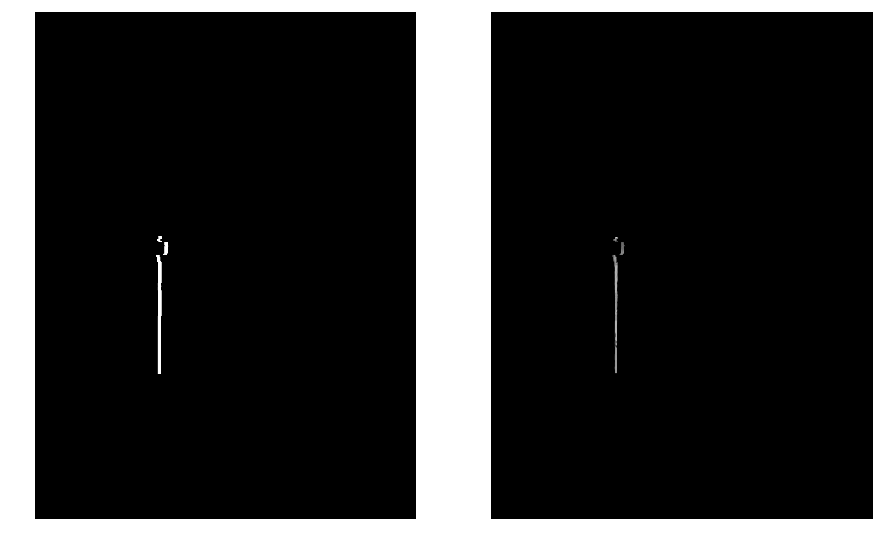

In [7]:
window = 4

begin()

peak = image_blur_threshold.argmax(axis=1)
_min = peak - window
_max = peak + window + 1
mask = np.zeros_like(image_blur_threshold)
for i in xrange(image_blur_threshold.shape[0]):
    mask[i, _min[i]:_max[i]] = 255

image_stripe = cv2.bitwise_and(image_diff_r, mask)

end()

plot_images((mask, image_stripe))

## Stripe detection
Using the previous masked image a smooth stripe of 1 px width is obtained.

### Peak detection
This is the simplest stripe detection. Despite its speed, the results have much noise.

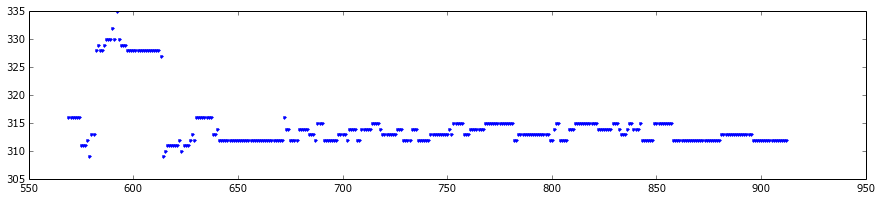

In [8]:
# Compute peak detection

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
peaks = image_stripe.argmax(axis=1)[v]

# Show peak detection

pylab.rcParams['figure.figsize'] = (15, 3)

plt.plot(v, peaks, '.')
plt.show()

### Center of mass
This method consist of computing the centroid of intensity for each row.

$$
\forall \: j \: \in  \: H :\:\:\:
cm_j = {\frac{\displaystyle\sum_{i}^{w} v_j · i}{\displaystyle\sum_{i}^{w} v_j}}
\: \Leftrightarrow \:
{\displaystyle\sum_{i}^{w} v_j} > 0 
$$

Time: 0:00:00.014853


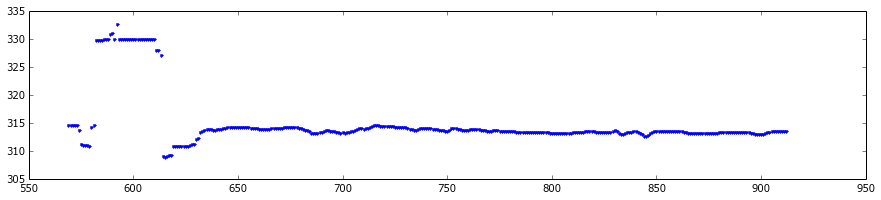

In [9]:
# Compute weight matrix

h, w = image_stripe.shape
weight_matrix = np.array((np.matrix(np.linspace(0, w - 1, w)).T * np.matrix(np.ones(h))).T)

# Compute center of mass

begin()

s = image_stripe.sum(axis=1)
v = np.where(s > 0)[0]
u = (weight_matrix * image_stripe).sum(axis=1)[v] / s[v]

end()
# Show center of mass

pylab.rcParams['figure.figsize'] = (15, 3)
    
plt.plot(v, u, '.')
plt.show()

## RANSAC
Center of mass method has better accuracy than peak detection, but stripe is not smooth enough. Asuming that the pattern is a plane surface, the best estimation of the laser plane intersection is a line.
In order to avoid speckles RANSAC is used instead of least squares.

Time: 0:00:00.016649


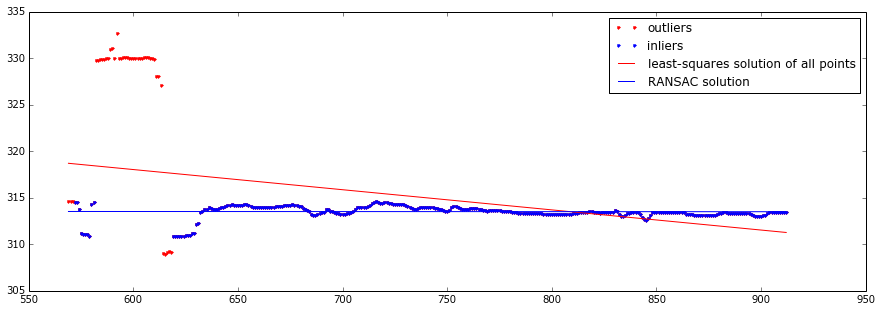

In [16]:
class LinearLeastSquares2D(object):
    '''
    2D linear least squares using the hesse normal form:
        d = x*sin(theta) + y*cos(theta)
    which allows you to have vertical lines.
    '''

    def fit(self, data):
        data_mean = data.mean(axis=0)
        x0, y0 = data_mean
        if data.shape[0] > 2:  # over determined
            u, v, w = np.linalg.svd(data - data_mean)
            vec = w[0]
            theta = math.atan2(vec[0], vec[1])
        elif data.shape[0] == 2:  # well determined
            theta = math.atan2(data[1, 0] - data[0, 0], data[1, 1] - data[0, 1])
        theta = (theta + math.pi * 5 / 2) % (2 * math.pi)
        d = x0 * math.sin(theta) + y0 * math.cos(theta)
        return d, theta

    def residuals(self, model, data):
        d, theta = model
        dfit = data[:, 0] * math.sin(theta) + data[:, 1] * math.cos(theta)
        return np.abs(d - dfit)

    def is_degenerate(self, sample):
        return False

def ransac(data, model_class, min_samples, threshold, max_trials=100):
    '''
    Fits a model to data with the RANSAC algorithm.
    :param data: numpy.ndarray
        data set to which the model is fitted, must be of shape NxD where
        N is the number of data points and D the dimensionality of the data
    :param model_class: object
        object with the following methods implemented:
         * fit(data): return the computed model
         * residuals(model, data): return residuals for each data point
         * is_degenerate(sample): return boolean value if sample choice is
            degenerate
        see LinearLeastSquares2D class for a sample implementation
    :param min_samples: int
        the minimum number of data points to fit a model
    :param threshold: int or float
        maximum distance for a data point to count as an inlier
    :param max_trials: int, optional
        maximum number of iterations for random sample selection, default 100
    :returns: tuple
        best model returned by model_class.fit, best inlier indices
    '''

    best_model = None
    best_inlier_num = 0
    best_inliers = None
    data_idx = np.arange(data.shape[0])
    for _ in xrange(max_trials):
        sample = data[np.random.randint(0, data.shape[0], 2)]
        if model_class.is_degenerate(sample):
            continue
        sample_model = model_class.fit(sample)
        sample_model_residua = model_class.residuals(sample_model, data)
        sample_model_inliers = data_idx[sample_model_residua < threshold]
        inlier_num = sample_model_inliers.shape[0]
        if inlier_num > best_inlier_num:
            best_inlier_num = inlier_num
            best_inliers = sample_model_inliers
    if best_inliers is not None:
        best_model = model_class.fit(data[best_inliers])
    return best_model, best_inliers


begin()

data = np.vstack((v.ravel(), u.ravel())).T
model, inliers = ransac(data, LinearLeastSquares2D(), 2, 2)

dr, thetar = model
f = (dr - v * math.sin(thetar)) / math.cos(thetar)

end()

ds, thetas = LinearLeastSquares2D().fit(data)
lr = (ds - v * math.sin(thetas)) / math.cos(thetas)

pylab.rcParams['figure.figsize'] = (15, 5)
plt.plot(data[:,0], data[:,1], '.r', label='outliers')
plt.plot(data[inliers][:,0], data[inliers][:,1], '.b', label='inliers')

plt.plot(v, lr, '-r', label='least-squares solution of all points')
plt.plot(v, f, '-b', label='RANSAC solution')

plt.legend(loc=1)
plt.show()

Total time: 0:00:00.055696


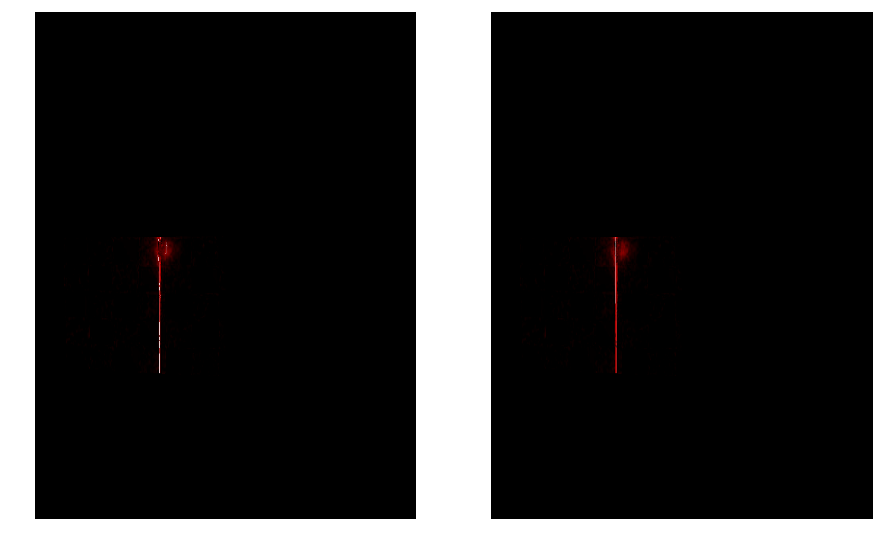

In [12]:
# Show images

image_line_cm = np.zeros_like(image_threshold)
image_line_lr = np.zeros_like(image_threshold)

image_line_cm[v, np.around(u).astype(int)] = 255
image_line_lr[v, np.around(f).astype(int)] = 255

image_cm = cv2.merge((cv2.add(image_diff_r, image_line_cm), image_line_cm, image_line_cm))
image_lr = cv2.merge((cv2.add(image_diff_r, image_line_lr), image_line_lr, image_line_lr))

total()

plot_images((image_cm, image_lr))

# References
* http://docs.opencv.org/doc/tutorials/imgproc/threshold/threshold.html
* https://github.com/ahojnnes/numpy-snippets/blob/master/ransac.py